In [20]:
# Import dependencies
import networkx as nx
import pandas as pd
import numpy as np
import time as tm
import math as math
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from openpyxl.utils.cell import range_boundaries
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import random
from matplotlib.animation import FuncAnimation
import json
%matplotlib inline

In [21]:
# Globals
DesignFile = 'modified_map5.xlsx'   # Excel layout filename, assumed to be in the same folder as this model
FreqFile = 'Frequency-small.xlsx'   # Excel file containing the frequency distribution of order lengths
MinOrderItems = 5   # Minimum number of items in an order (minimum order length)
MaxOrderItems = 10   # Maximum number of items in an order (maximum order length)
NumIters = 20   # Number of iterations for each order length. Use 1 for testing; say 1000 for final analysis
ItemRatio = 1   # Ratio of most frequently ordered item to least frequently order item. 1 = uniform distribution
DiagnosticsOn = True   # Display detailed diagnoistic data. Only set to True for small layouts, as the run time can be long and output copious
Verbose = True   # Print updates as the model proceeds

DesignWorksheet = 'Sheet1'   # Excel worksheet name containing the layout
DesignRange = 'test'   # Excel named range that defines the layout cells
FreqWorksheet = 'Distribution'   # Excel worksheet name with freqency data
FreqRange = 'Frequency'   # Excel named range that defines the order frequency data

IntMultiplier = 1000   # Factor to make everything integer for OR-Tools, including costs. A factor of 1000 should be sufficient

Checkpoints = []   # List of time checkpoints
Lengths = []   # Average length of TSP tour for each order length

In [22]:
# Load layout from Excel file to pandas dataframe
def LoadFromExcel(ExcelFile, Worksheet, Range):
    wb = load_workbook(filename=ExcelFile, read_only=True)
    ws = wb[Worksheet]
    dests = wb.defined_names[Range].destinations
    for title, coord in dests:
        min_col, min_row, max_col, max_row = range_boundaries(coord)
        data = ws.iter_rows(min_row, max_row, min_col, max_col, values_only=True)
    ExcelData = pd.DataFrame(data)
    return ExcelData

In [23]:
# Create array of cell number labels.
# Cells are labelled from west-to-east and from north-to-south. row1.e. top-left = 1, bottom-right = n
def ApplyLabels(rows, columns):
    currLabel = 1
    data = []
    for r in range(0, rows):
        column = []
        for c in range(0, columns):
            column.append(str(currLabel))
            currLabel += 1
        data.append(column)
    labels = pd.DataFrame(data)
    return labels


In [24]:
# Build edgelist
def ConstructAdjacency(Layout, Labels, rows, columns):
    node1 = []
    node2 = []
    weight = []
    cardinal = 5
    diagoanal = 5*(2**0.5)

    for row1 in range(rows):
        for column1 in range(columns):
            if Layout.loc[row1,column1].lower() in ('start','end','w'):
                for row2 in range(rows):
                    for column2 in range(columns):
                        if Layout.loc[row2,column2].lower() in ('start','end','w'):
                            # check if adjacent
                            if (abs(row2-row1) <= 1) and (abs(column2-column1) <= 1) and not(row1 == row2 and column1 == column2):
                                node1.append(Labels.loc[row1,column1])
                                node2.append(Labels.loc[row2,column2])
                                # add weight
                                if (row1 == row2) or (column1 == column2):
                                    weight.append(cardinal)
                                else:
                                    weight.append(diagoanal)
    
    edgelist = pd.DataFrame({
        'node1': node1,
        'node2': node2,
        'weights':weight
    })
    return edgelist

In [25]:
# Create adjacency graph
def CreateGraph(Adjacency):
    g = nx.DiGraph()
    for i, elrow in Adjacency.iterrows():
        g.add_edge(elrow['node1'], elrow['node2'], stepsize=round(elrow['weights'],3))
    return g


In [26]:
def SpotMatrix(Layout, Labels, rows, columns):
    name = []
    Cell = []
    Spot = []
    row_column = []
    cartesian = []
    name_count = 0
    # 1st loop: check start and end nodes
    for row1 in range(rows):
        for column1 in range(columns):
            if Layout.loc[row1, column1].lower() == 'start':
                Cell.append(Labels.loc[row1, column1])
                Spot.append(Labels.loc[row1, column1])
                row_column.append((row1, column1))  # Add row_column coordinates
                cartesian.append((-column2,row2))
    for row1 in range(rows):
        for column1 in range(columns):
            if Layout.loc[row1, column1].lower() == 'end':
                Cell.append(Labels.loc[row1, column1])
                Spot.append(Labels.loc[row1, column1])
                row_column.append((row1, column1))  # Add row_column coordinates
                cartesian.append((-column2,row2))
    # 2nd loop: check spots for cardinal neighbors (clearways)
    for row1 in range(rows):
        for column1 in range(columns):
            if Layout.loc[row1, column1].lower() == 's':
                cardinal_neighbors = [(row1-1, column1), # North
                                      (row1+1, column1), # South
                                      (row1, column1-1), # West
                                      (row1, column1+1)] # East
                for row2, column2 in cardinal_neighbors:
                    if 0 <= row2 < rows and 0 <= column2 < columns:  # Ensure within bounds
                        if Layout.loc[row2, column2].lower() == 'w':
                            Cell.append(Labels.loc[row1, column1])
                            Spot.append(Labels.loc[row2, column2])
                            row_column.append((row2, column2))  # Add row_column coordinates
                            cartesian.append((column2,-row2))
                            name.append(name_count)
                            name_count += 1
                            
    edgelist = pd.DataFrame({'name': name, 'Cell': Cell, 'Spot': Spot, 'row_column': row_column, 'Cartesian': cartesian})
    #just swap depot @ 7 to 0
    temp_row = edgelist.loc[0, ['Cell', 'Spot', 'row_column', 'Cartesian']].copy()
    edgelist.loc[0, ['Cell', 'Spot', 'row_column', 'Cartesian']] = edgelist.loc[7, ['Cell', 'Spot', 'row_column', 'Cartesian']]
    edgelist.loc[7, ['Cell', 'Spot', 'row_column', 'Cartesian']] = temp_row
    return edgelist

In [27]:
# Shortest distance between two spots, using networkx
def NetworkxPath(DesignGraph, input_node, output_node):
    PathLength = nx.shortest_path_length(DesignGraph, source = input_node, target = output_node, weight='stepsize')
    return PathLength

In [28]:
# Create matrix of shortest paths between all spot cells
def Distances(Spots, DesignGraph):
    ShortestPaths = pd.DataFrame(index=range(len(Spots)), columns=range(len(Spots)))
    for row in range(len(Spots)):
        for column in range(len(Spots)):
            if row == column:
                ShortestPaths.at[row,column] = 0
            else:
                PathLength = NetworkxPath(DesignGraph, Spots.loc[row]['Spot'], Spots.loc[column]['Spot'])
                Decimals = round(math.log(IntMultiplier,10))
                ShortestPaths.at[row, column] = round(PathLength, Decimals)   # Upper-right triangle of matrix
                ShortestPaths.at[column, row] = round(PathLength, Decimals)   # Lower-left triangle of matrix
    dist = ShortestPaths.astype(int)
    return dist

In [29]:
def ItemsDistn(Spots, Dists):
    SpotsDistn = pd.DataFrame(Spots)
    SpotsDistn = SpotsDistn.drop(0)  # drop depor at 0
    SpotsDistn.insert(loc=2, column="RowNum", value=SpotsDistn.reset_index().index)
    SpotsDistn['DistanceBegin'] = Dists.iloc[:, 0]
    SpotsDistn = SpotsDistn.sort_values(by=['DistanceBegin'])
    
    d = (1/ItemRatio)**(1/(len(SpotsDistn)-1))   # Compounding diminishing factor
    Raw = []
    Raw.append(1)
    RawSum = Raw[0]
    for r in range(1, len(SpotsDistn)):
        Raw.append(Raw[r-1] * d)
        RawSum += Raw[r]
    Probability = []
    Probability.append(Raw[0] / RawSum)
    for s in range(1, len(SpotsDistn)):
        Probability.append(Raw[s] / RawSum)
    SpotsDistn['Probability'] = Probability
    SpotsDistn = SpotsDistn.sort_values(by=['RowNum'])
    return SpotsDistn

In [30]:
# Create random sample of shelves, representing an order
def CreateOrder(Spots, SpotsDistn, OrderLength):
    Items = SpotsDistn['name']
    Prob = SpotsDistn['RowNum']
    Position = np.random.choice(a=Items, size=OrderLength, replace=False)
    depot = Spots.iloc[0,0]
    OrderList = []
    OrderList.append(depot)   # Order list consists of b, e, and specified number of other cells
    OrderList.extend(Position)
    OrderList = [int(x) for x in OrderList]
    OrderListSort = sorted(OrderList)
    return OrderListSort

In [31]:
# Extract shortest path matrix for current Order
def DistancesSubset(Order, Spots, Dists):
    data = []
    for d1 in range(0, len(Order)):
        for r in range(0, len(Spots)):
            if Spots.loc[r][0] == Order[d1]:
                CurrRow = []
                for d2 in range(0, len(Order)):
                    for c in range(0, len(Spots)):
                        if Spots.loc[c][0] == Order[d2]:
                            CurrRow.append(Dists[r][c])
                data.append(CurrRow)
    Subset = pd.DataFrame(data)
    return Subset

# Start VRP 

In [32]:
def create_data_model(Distances,order):
    Orderdistance = Distances.loc[order,order]
    Orderdistances = Orderdistance.values.tolist()
    data = {}
    data["distance_matrix"] = Orderdistances
    data["num_vehicles"] = 4
    data["depot"] = 0 # node @ 7
    return data

In [33]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    #print(f"Objective: {solution.ObjectiveValue()}")
    max_route_distance = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f" {manager.IndexToNode(index)} -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f"{manager.IndexToNode(index)}\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        #print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    #print(f"Maximum of the route distances: {max_route_distance}m")
    return max_route_distance

In [34]:
def get_routes(solution, routing, manager):
  """Get vehicle routes from a solution and store them in an array."""
  # Get vehicle routes and store them in a two dimensional array whose
  # i,j entry is the jth location visited by vehicle i along its route.
  routes = []
  for route_nbr in range(routing.vehicles()):
    index = routing.Start(route_nbr)
    route = [manager.IndexToNode(index)]
    while not routing.IsEnd(index):
      index = solution.Value(routing.NextVar(index))
      route.append(manager.IndexToNode(index))
    routes.append(route)
  return routes

In [35]:
def VRP(Distances,order):
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model(Distances,order)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = "Distance"
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        1000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name,
    )
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        max_route_distance = print_solution(data, manager, routing, solution)
        route = get_routes(solution, routing, manager)
        return max_route_distance, route
    else:
        print("No solution found !")

In [36]:
def MapRouteToNodeByOrder(routes,orders):
    # Remove unused routes [0,0]
    filtered_routes = [route for route in routes if len(route) != 2]
    maps = []
    for filtered_route in filtered_routes:
        map = []
        for route in filtered_route:
            map.append(orders[route])
        maps.append(map)
    return maps

# Plot animation and graph

In [37]:
def plot_spots_with_cartesian(edgelist, distance_matrix):
    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(edgelist['name'])

    # Extract depot and elements
    depot = edgelist.iloc[0]
    elements = edgelist.drop(0)

    # Create a dictionary for node positions
    pos = {row['name']: row['Cartesian'] for _, row in edgelist.iterrows()}

    # Add fully connected edges using the distance matrix
    for i in range(len(distance_matrix)):
        for j in range(i + 1, len(distance_matrix)):
            node_i = edgelist.iloc[i]['name']
            node_j = edgelist.iloc[j]['name']
            distance = distance_matrix.iloc[i, j]
            G.add_edge(node_i, node_j, weight=distance)

    # Plot settings
    plt.figure(figsize=(10, 10))  # Increase figure size

    # Plot the depot node in red
    nx.draw_networkx_nodes(G, pos, nodelist=[depot['name']], node_color='red', node_size=500)

    # Plot the other spot nodes in blue
    nx.draw_networkx_nodes(G, pos, nodelist=elements['name'], node_color='blue', node_size=500)

    # Add labels to the nodes
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

    # Draw the edges with a thicker line width
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=2)

    # Optionally, add edge labels for distances
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Show the plot
    plt.title('Spot Nodes with Cartesian Coordinates and Distance Matrix')
    plt.grid(True)  # Optionally add a grid for better readability
    plt.show()

    #return G, pos

    0  1  2  3  4  5  6  7  8  9   ... 54 55 56 57 58 59 60 61 62 63
0    b  b  b  b  b  b  b  b  b  b  ...  b  b  b  b  b  b  b  b  b  b
1    b  n  n  n  n  n  n  n  n  n  ...  o  o  n  n  n  n  n  n  n  n
2    b  n  n  n  n  n  n  n  n  n  ...  o  o  n  n  n  n  n  n  n  n
3    b  n  n  n  n  n  n  n  n  n  ...  o  o  n  n  n  n  n  n  n  n
4    b  n  n  n  n  n  n  n  n  n  ...  o  o  n  n  n  n  n  n  n  n
..  .. .. .. .. .. .. .. .. .. ..  ... .. .. .. .. .. .. .. .. .. ..
105  b  g  g  g  g  g  g  g  g  g  ...  m  m  m  m  m  m  m  m  w  w
106  b  g  g  g  g  g  g  g  g  g  ...  m  m  m  m  m  m  m  m  w  w
107  b  w  w  w  w  w  w  w  w  w  ...  w  w  w  w  w  w  w  w  w  w
108  b  w  w  w  w  w  w  w  w  w  ...  w  w  w  w  w  w  w  w  w  w
109  b  b  b  b  b  b  b  b  b  b  ...  b  b  b  b  b  b  b  b  b  b

[110 rows x 64 columns]

rows 110 columns 64
       0     1     2     3     4     5     6     7     8     9   ...    54  \
0       1     2     3     4     5     6     7   

KeyError: 21

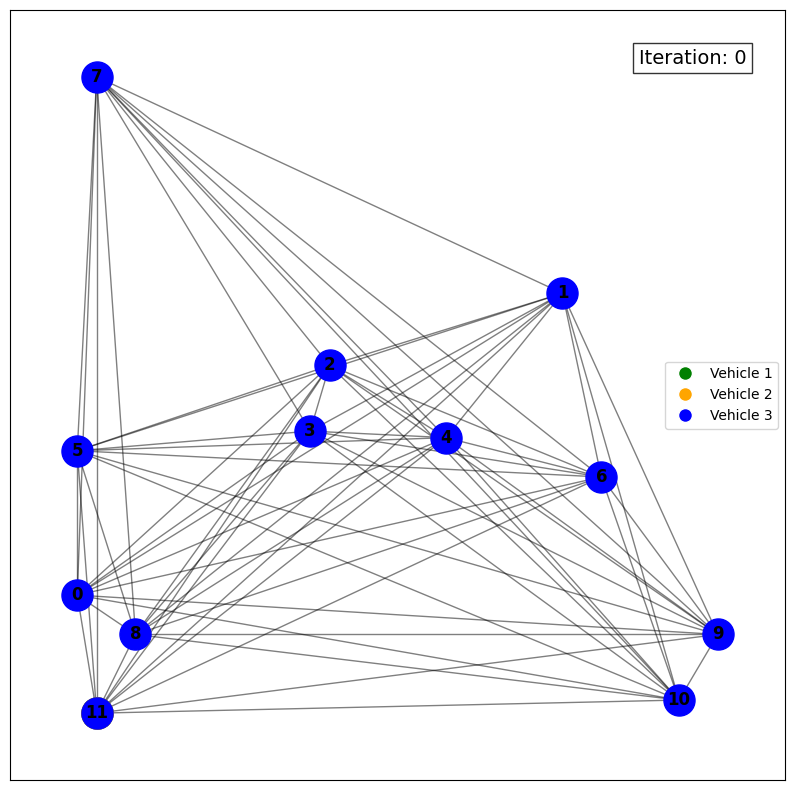

In [38]:
def main():
    Layout = LoadFromExcel(DesignFile,DesignWorksheet,DesignRange)   
    print(Layout)

    rows,columns = Layout.shape
    print(f"\nrows {rows} columns {columns}")

    Labels = ApplyLabels(rows, columns)
    print(Labels)
    
    Adjacency = ConstructAdjacency(Layout, Labels, rows, columns)
    print(Adjacency)

    DesignGraph = CreateGraph(Adjacency)
    print(DesignGraph)

    Spots = SpotMatrix(Layout, Labels, rows, columns)
    print(Spots)

    Dis = Distances(Spots, DesignGraph)
    print(Dis)

    Spotsdist = ItemsDistn(Spots, Dis)
    print(Spotsdist)

    memory = {}
    orders = []
    count = 0
    for i in range(NumIters):
        order = CreateOrder(Spots, Spotsdist, OrderLength=random.randint(MinOrderItems, MaxOrderItems))
        max_route_distance, route = VRP(Dis,order)
        route_by_order = MapRouteToNodeByOrder(route,order)
        # using max_route_distance and route_by_order
        memory[count] = route_by_order
        num = len(order)
        orders.append(num)
        count += 1

    for key, value in memory.items():
        print(f"{key}: {value}")

    print(orders)

  # Initialize the iteration dictionary
    #iteration = {}

    # Populate the iteration dictionary
    #for vehicle_id, routes in memory.items():
        #iteration[f'vrp{vehicle_id}'] = {}
        #for route_index, route in enumerate(routes):
            #iteration[f'vrp{vehicle_id}'][f'vehicle{route_index}'] = route

    # Print the resulting dictionary in a readable format
    #print(json.dumps(iteration, indent=4)) 

    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(Spots['name'])

    # Extract depot and elements
    depot = Spots.iloc[0]
    elements = Spots.drop(0)

    # Create a dictionary for node positions
    pos = {row['name']: row['Cartesian'] for _, row in Spots.iterrows()}

    # Add fully connected edges using the distance matrix
    for i in range(len(Dis)):
        for j in range(i + 1, len(Dis)):
            node_i = Spots.iloc[i]['name']
            node_j = Spots.iloc[j]['name']
            distance = Dis.iloc[i, j]
            G.add_edge(node_i, node_j, weight=distance)

    fig, ax = plt.subplots(figsize=(10, 10))

    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='blue', node_size=500)
    # Highlight the depot node
    nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=[Spots.iloc[0]['name']], node_color='red', node_size=700)
    # Draw all edges
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', width=1)

    # Convert node indices to labels
    def convert_routes_to_labels(routes):
        return [[i for node in route] for route in routes]

    # Define colors for vehicles
    colors = ['green', 'orange', 'blue', 'red']

    # Function to update the animation
    def update(frame):
        iteration = frame // max(len(route) for route in memory[frame % 20])  # Determine iteration number
        frame_in_iteration = frame % max(len(route) for route in memory[frame % 20])
        
        ax.clear()  # Clear previous frame
        nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.5)
        nx.draw_networkx_nodes(G, pos, ax=ax, node_color='blue', node_size=500)
        nx.draw_networkx_labels(G, pos, ax=ax, font_size=12, font_weight='bold')

        # Plot the path for each vehicle in the current iteration
        routes = convert_routes_to_labels(memory[iteration])
        for idx, route in enumerate(routes):
            path = route[:frame_in_iteration + 1]
            if len(path) > 1:
                nx.draw_networkx_edges(G, pos, edgelist=[(path[i], path[i + 1]) for i in range(len(path) - 1)], ax=ax,
                                    edge_color=colors[idx % len(colors)], width=2, alpha=0.7)
            
            # Plot the vehicle's position
            nx.draw_networkx_nodes(G, pos, nodelist=[path[-1]], node_color=colors[idx % len(colors)], node_size=500, label=f'Vehicle {idx+1}')

        # Add iteration label
        ax.text(0.95, 0.95, f'Iteration: {iteration}', transform=ax.transAxes, fontsize=14,
                verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

        # Add a legend for vehicle colors
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Vehicle {idx+1}') for idx, color in enumerate(colors[:len(routes)])]
        ax.legend(handles=handles)

    # Create the animation
    frames = sum(len(route) for routes in memory.values() for route in routes)
    ani = FuncAnimation(fig, update, frames=frames, repeat=False, interval=1000)

    ani.save('animation.gif', writer='pillow')






    #order = CreateOrder(Spots, Spotsdist, 5)
    #print(order)
    # print(create_data_model(Dis,order)) for check

    #max_route_distance, route = VRP(Dis,order)
    #print(max_route_distance, route)

    #route_by_order = MapRouteToNodeByOrder(route,order)
    #print(route_by_order)
    # using max_route_distance and route_by_order 


    #plot_spots_with_cartesian(Spots,Dis)
    
    # animate
    #start_node = random.choice(list(G.nodes))
    #path = random_walk(G, start_node, num_steps=15)
    #animate_walk(G, pos, path)
    #PlotGraph(DesignGraph, Layout, Labels, rows, columns, Spots)
    
main()

In [ ]:
# Plot adjacency graph, augmented with additional information
def PlotGraph(g, Layout, Labels, rows, columns, Spots):
    currName = 0
    for r in range(1, rows+1):
        for c in range(1, columns+1):
            currName += 1
            g.add_node(str(currName), pos = (c, rows-r))
    
    pos = nx.get_node_attributes(g,'pos')
    weight = nx.get_edge_attributes(g,'stepsize')
    NodeSize = 1500
    options1 = {'edgecolors': 'black', 'node_size': NodeSize, 'alpha': 1.0}
    options2 = {'node_size': 0}
    plt.figure(figsize=(rows*1, columns*1))
    Nodes1 = []
    Nodes2 = []
    NodeColourList1 = []
    ColorDict = {'w': '#D9D9D9','n': '#E7E4DB', 's': '#c00000', 'b': '#000000','o': '#F7C7AC',
                 'g': '#B5E6A2','p': '#F2CEEF', 'l': '#A6C9EC', 'm': '#D86DCD','spot': 'orange'}
    for row in range(0, rows):
        for column in range(0, columns):
            nodeColor = ColorDict[Layout.loc[row, column]]
            for CurrSpot in range(2, len(Spots)):
                if Labels.loc[row, column] == Spots.iloc[CurrSpot][1]:
                    nodeColor = ColorDict['spot']
            Nodes1.append(Labels.loc[row, column])
            NodeColourList1.append(nodeColor)
            if Layout.loc[row, column].lower() == 'b':
                Nodes2.append(Labels.loc[row, column])
    nx.draw(g, pos, nodelist=Nodes1, with_labels=True, font_color='Black', font_size=18, node_color=NodeColourList1, **options1)
    nx.draw(g.subgraph(Nodes2), pos, with_labels=True, font_color='White', font_size=18, **options2)
    nx.draw_networkx_edges(g, pos, node_size=NodeSize, arrowsize=20)
    SpotConnect = nx.DiGraph()
    for i, elrow in Spots.iterrows():
        SpotConnect.add_edge(elrow[0], elrow[1])
    nx.draw_networkx_edges(SpotConnect, pos, node_size=NodeSize, arrowsize=20, width=3.0, edge_color=ColorDict['spot'])
    plt.show()